# Import Libraries 


In [64]:
## EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap

## feature engineering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

## model preparation libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## model evaluation libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

## model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib
%matplotlib inline

# Import Data And Preprocessing

According to data dictionary, we have 3 unknown fields. If the regression is a multivariate problem, then **fruitset, fruitmass, seeds** will be the part of target variables. otherwise, we'll focus on predicting the **yield** value.

1. we have a data dictionary of mutual correlated values of each of the fields with yield values
2. as this clearly is a regression problem, we can perform feature selection on the data
3. there are the following approaches:
    * f_regression() parameter for selecting by correlation
    * mutual_info_regression() for selecting by information gain
    * raw data features kept intact

In [2]:
berry_data = pd.read_csv('WildBlueberryPollinationSimulationData.csv')
berry_data.head(20)

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543
5,5,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.309669,0.366284,27.345453,2825.003738
6,6,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.284443,0.352186,26.101179,2625.269164
7,7,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.246568,0.342826,25.042361,2379.905214
8,8,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.427977,0.414711,32.334153,4234.868585
9,9,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.464366,0.436346,34.849953,5356.871861


In [3]:
berry_data.isna().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [4]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_info

In [5]:
X13 = berry_data.drop(["yield", "Row#", "fruitmass", "fruitset", "seeds"], axis=1)
y = berry_data["yield"]

X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, y, test_size=0.33, random_state=1)

X_train_fs_corr13, X_test_fs_corr13, fs_corr13 = select_features_corr_based(X_train13, y_train13, X_test13)
X_train_fs_info13, X_test_fs_info13, fs_info13 = select_features_infogain_based(X_train13, y_train13, X_test13)

In [6]:
X17 = berry_data.drop(["yield", "Row#"], axis=1)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X17, y, test_size=0.33, random_state=1)

X_train_fs_corr17, X_test_fs_corr17, fs_corr17 = select_features_corr_based(X_train17, y_train17, X_test17)
X_train_fs_info17, X_test_fs_info17, fs_info17 = select_features_infogain_based(X_train17, y_train17, X_test17)

# Exploratory Data Analysis

In [7]:
berry_data.shape

(777, 18)

In [8]:
berry_data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

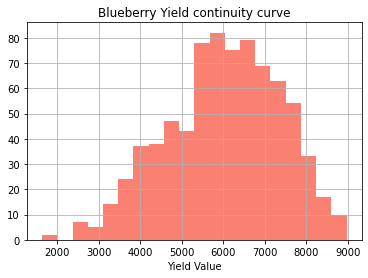

In [9]:
plt.grid()
plt.title("Blueberry Yield continuity curve")
plt.xlabel("Yield Value")
plt.hist(x=berry_data["yield"], bins=20, color="salmon");

**I would have to perform many folds of tuning on the decided dataset, hence I would have to choose either one option of the below**

* info-gain vs correlation
* 13 features vs 17 features

each of the selected dataset will go through 2-3 modelling and 2-3 tuning

Feature 0: 184.510812
Feature 1: 56.025407
Feature 2: 56.110457
Feature 3: 8.547399
Feature 4: 115.949147
Feature 5: 10.584235
Feature 6: 8.223105
Feature 7: 9.465591
Feature 8: 10.721786
Feature 9: 9.746869
Feature 10: 9.334603
Feature 11: 207.887147
Feature 12: 211.684877


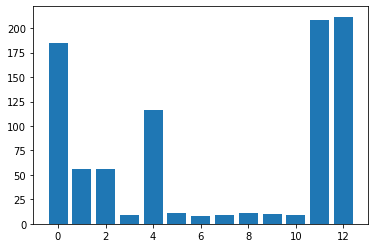

Feature 0: 0.140612
Feature 1: 0.100463
Feature 2: 0.072651
Feature 3: 0.045719
Feature 4: 0.111916
Feature 5: 0.086794
Feature 6: 0.089264
Feature 7: 0.082927
Feature 8: 0.093771
Feature 9: 0.086167
Feature 10: 0.082110
Feature 11: 0.192453
Feature 12: 0.193117


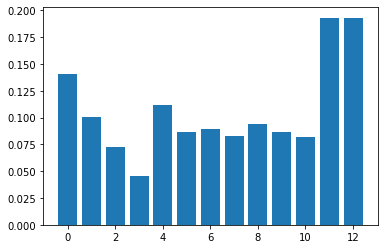

In [10]:
def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.scores_)):
        print('Feature %d: %f' % (i, fs_func.scores_[i]))
    # plot the scores
    plt.bar([i for i in range(len(fs_func.scores_))], fs_func.scores_)
    plt.show()
    
fs_score_plot(fs_corr13)
fs_score_plot(fs_info13)

Feature 0: 184.510812
Feature 1: 56.025407
Feature 2: 56.110457
Feature 3: 8.547399
Feature 4: 115.949147
Feature 5: 10.584235
Feature 6: 8.223105
Feature 7: 9.465591
Feature 8: 10.721786
Feature 9: 9.746869
Feature 10: 9.334603
Feature 11: 207.887147
Feature 12: 211.684877
Feature 13: 16312.305141
Feature 14: 3614.015492
Feature 15: 7675.208274


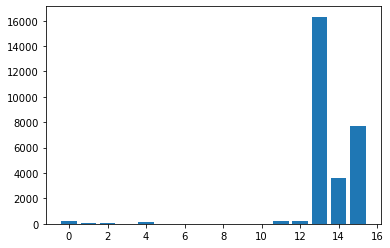

Feature 0: 0.141735
Feature 1: 0.095795
Feature 2: 0.071217
Feature 3: 0.055560
Feature 4: 0.111252
Feature 5: 0.089400
Feature 6: 0.088860
Feature 7: 0.083424
Feature 8: 0.088467
Feature 9: 0.083577
Feature 10: 0.082145
Feature 11: 0.191491
Feature 12: 0.194461
Feature 13: 1.950900
Feature 14: 1.614620
Feature 15: 1.636104


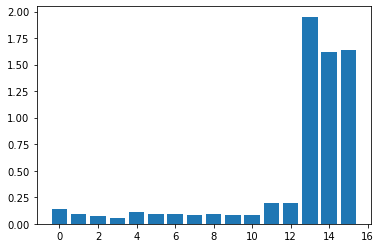

In [11]:
fs_score_plot(fs_corr17)
fs_score_plot(fs_info17)

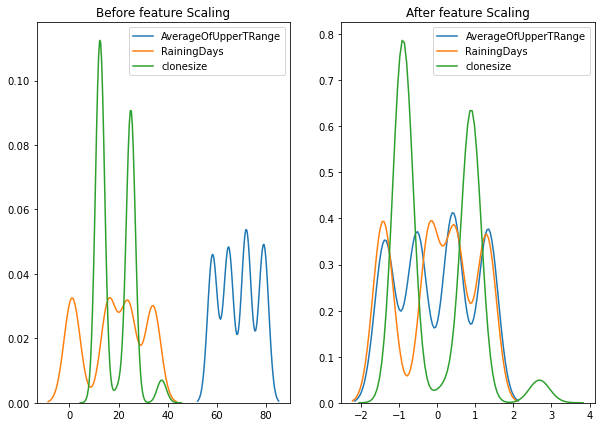

In [12]:
sc = StandardScaler()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 7))
ax1.set_title('Before feature Scaling')
sns.kdeplot(berry_data["AverageOfUpperTRange"], ax=ax1)
sns.kdeplot(berry_data["RainingDays"], ax=ax1)
sns.kdeplot(berry_data["clonesize"], ax=ax1)

scaled_berry_data = pd.DataFrame(sc.fit_transform(berry_data), columns=berry_data.columns)
ax2.set_title('After feature Scaling')
sns.kdeplot(scaled_berry_data["AverageOfUpperTRange"], ax=ax2)
sns.kdeplot(scaled_berry_data["RainingDays"], ax=ax2)
sns.kdeplot(scaled_berry_data["clonesize"], ax=ax2)
plt.show()

In [13]:
# plt.scatter(x = berry_data["yield"], y= berry_data["honeybee"])

# Modelling 

X_train_fs_info2, X_test_fs_info2, fs_info2 with 17
X_train_fs_info1, X_test_fs_info1, fs_info1 with 13
taking 13/17 features

train-test split into X-13 and X-17, y= "yield". 
without scaler scores calculated and plotted above.

scaled with standard scaler and derived info-gain-powered features in x-train-13-info-fs x-test-13-info-fs same with 17. 
modeled to find the most suitable.

In [14]:

X_train13 = sc.fit_transform(X_train13)
X_train17 = sc.fit_transform(X_train17)
X_test13 = sc.fit_transform(X_test13)
X_test17 = sc.fit_transform(X_test17);

X_train_fs_info13, X_test_fs_info13, fs_info13 = select_features_infogain_based(X_train13, y_train13, X_test13, x=10)
X_train_fs_info17, X_test_fs_info17, fs_info17 = select_features_infogain_based(X_train17, y_train17, X_test17, x=10)

X_train_fs_info13.shape

(520, 10)

### LinearRegression

In [15]:
lreg = LinearRegression()

lreg.fit(X_train_fs_info13, y_train13)

yhat13 = lreg.predict(X_test_fs_info13)



In [16]:
mae13_linear = mean_absolute_error(y_test13, yhat13)
mse13_linear = mean_squared_error(y_test13, yhat13)
rmse13_linear = np.sqrt(mse13_linear)

print('MAE: %.3f' % mae13_linear)
print('MSE: %.3f' % mse13_linear)
print('RMSE: %.3f' % rmse13_linear)

MAE: 562.959
MSE: 603855.975
RMSE: 777.082


In [17]:
lreg.fit(X_train_fs_info17, y_train17)

yhat17 = lreg.predict(X_test_fs_info17)


In [18]:
mae17_linear = mean_absolute_error(y_test17, yhat17)
mse17_linear = mean_squared_error(y_test17, yhat17)
rmse17_linear = np.sqrt(mse17_linear)

print('MAE: %.3f' % mae17_linear)
print('MSE: %.3f' % mse17_linear)
print('RMSE: %.3f' % rmse17_linear)

MAE: 150.309
MSE: 35205.909
RMSE: 187.632


### RandomForest Regression

In [19]:
rf = RandomForestRegressor()

rf.fit(X_train_fs_info13, y_train13)
    
yhat13 = rf.predict(X_test_fs_info13)

In [20]:
mae13_rf = mean_absolute_error(y_test13, yhat13)
mse13_rf = mean_squared_error(y_test13, yhat13)
rmse13_rf = np.sqrt(mse13_rf)

print('MAE: %.3f' % mae13_rf)
print('MSE: %.3f' % mse13_rf)
print('RMSE: %.3f' % rmse13_rf)

MAE: 386.358
MSE: 249198.852
RMSE: 499.198


In [21]:
rf.fit(X_train_fs_info17, y_train17)

yhat17 = rf.predict(X_test_fs_info17)

In [22]:
mae17_rf = mean_absolute_error(y_test17, yhat17)
mse17_rf = mean_squared_error(y_test17, yhat17)
rmse17_rf = np.sqrt(mse17_rf)

print('MAE: %.3f' % mae17_rf)
print('MSE: %.3f' % mse17_rf)
print('RMSE: %.3f' % rmse17_rf)

MAE: 147.881
MSE: 43455.660
RMSE: 208.460


### Decision Tree Regression

In [23]:
dtree = DecisionTreeRegressor()

dtree.fit(X_train_fs_info13, y_train13)

yhat13 = dtree.predict(X_test_fs_info13)

In [24]:
mae13_dtree = mean_absolute_error(y_test13, yhat13)
mse13_dtree = mean_squared_error(y_test13, yhat13)
rmse13_dtree = np.sqrt(mse13_dtree)

print('MAE: %.3f' % mae13_dtree)
print('MSE: %.3f' % mse13_dtree)
print('RMSE: %.3f' % rmse13_dtree)

MAE: 407.782
MSE: 286998.741
RMSE: 535.723


In [25]:
dtree.fit(X_train_fs_info17, y_train17)

yhat17 = dtree.predict(X_test_fs_info17)

In [26]:
mae17_dtree = mean_absolute_error(y_test17, yhat17)
mse17_dtree = mean_squared_error(y_test17, yhat17)
rmse17_dtree = np.sqrt(mse17_dtree)

print('MAE: %.3f' % mae17_dtree)
print('MSE: %.3f' % mse17_dtree)
print('RMSE: %.3f' % rmse17_dtree)

MAE: 168.230
MSE: 55308.616
RMSE: 235.178


### XGBRegression

In [27]:
xgb = XGBRegressor()

xgb.fit(X_train_fs_info13, y_train13)

yhat13 = xgb.predict(X_test_fs_info13)

d:\softwares\python3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [28]:
mae13_xgb = mean_absolute_error(y_test13, yhat13)
mse13_xgb = mean_squared_error(y_test13, yhat13)
rmse13_xgb = np.sqrt(mse13_xgb)

print('MAE: %.3f' % mae13_xgb)
print('MSE: %.3f' % mse13_xgb)
print('RMSE: %.3f' % rmse13_xgb)

MAE: 374.147
MSE: 228185.676
RMSE: 477.688


In [29]:
xgb.fit(X_train_fs_info17, y_train17)

yhat17 = xgb.predict(X_test_fs_info17)

d:\softwares\python3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [30]:
mae17_xgb = mean_absolute_error(y_test17, yhat17)
mse17_xgb = mean_squared_error(y_test17, yhat17)
rmse17_xgb = np.sqrt(mse17_xgb)

print('MAE: %.3f' % mae17_xgb)
print('MSE: %.3f' % mse17_xgb)
print('RMSE: %.3f' % rmse17_xgb)

MAE: 145.976
MSE: 42165.763
RMSE: 205.343


# Model Evaluation


In [39]:
# CV evaluation for all the models
# from sklearn.metrics import r2_score

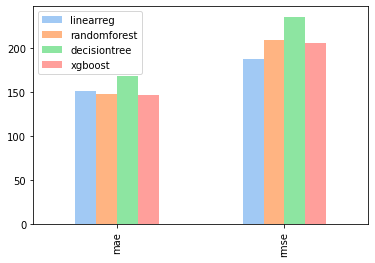

In [32]:
error_rec = {
    "linearreg": {
        "mae": mae17_linear,
        "rmse": rmse17_linear
    },
    "randomforest": {
        "mae": mae17_rf,
        "rmse": rmse17_rf
    },
    "decisiontree": {
        "mae": mae17_dtree,
        "rmse": rmse17_dtree
    },
    "xgboost": {
        "mae": mae17_xgb,
        "rmse": rmse17_xgb
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);


# Hyperparameter Tuning

In [33]:
cv = RepeatedKFold(n_splits= 78,n_repeats = 3,random_state = 1)
fs_info_v0 = SelectKBest(score_func = mutual_info_regression)

# y_test17, yhat17, X_train_fs_info13, y_train13, X_test_fs_info13 (basic models)
# 
# define pipeline for each algorithm
# define GSCV for each
# loop through it


pipe_lr = Pipeline([
    ('sel', fs_info_v0), 
    ('model', LinearRegression())
])

pipe_rf = Pipeline([
    ('sel', fs_info_v0), 
    ('model', RandomForestRegressor(random_state=1))
])

pipe_dtree = Pipeline([
    ('sel', fs_info_v0), 
    ('model', DecisionTreeRegressor(random_state=1))
])

pipe_xgb = Pipeline([
    ('sel', fs_info_v0), 
    ('model', XGBRegressor(random_state=1))
])

# pipe_lr.get_params().keys()

In [53]:
param_range = [15, 18, 10]
param_range_fl = [5.0, 10.0]

grid_params_lr = [{'sel__k': [i for i in range(X_train17.shape[1]-6, X_train17.shape[1]-4)],
        }] 


grid_params_rf = [{'sel__k': [i for i in range(X_train17.shape[1]-6, X_train17.shape[1]-4)],
        'model__criterion': ['mse', 'mae'],
#         'model__max_depth': param_range,
#         'model__min_samples_split': param_range[1:]
                  }]


grid_params_dtree = [{'sel__k': [i for i in range(X_train17.shape[1]-6, X_train17.shape[1]-4)],
                    'model__criterion': ['mse', 'mae'],
#                      'model__max_depth': param_range,
#                      'model__max_features': ['auto', 'sqrt']
                     }]


grid_params_xgb = [{'sel__k': [i for i in range(X_train17.shape[1]-6, X_train17.shape[1]-4)],
#                     'model__max_depth': [9,12],
#                    'model__min_child_weight': [7,8],
                   'model__subsample': [i/10. for i in range(9,11)]
                   }]



LR = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='neg_mean_absolute_error',
            cv=cv)

RF = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

DT = GridSearchCV(estimator=pipe_dtree,
            param_grid=grid_params_dtree,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

XGB = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

grids = [LR,RF,XGB,DT]

# Creating a dict for our reference
grid_dict = {0: 'Logistic Regression', 
        1: 'Random Forest',
        2: 'XGBoost',
        3: 'Decision Tree'}

In [54]:
# store the error values in a dataframe and plot as evaluation visualization also see boosted DTree and R2 square values

In [55]:
# Start form initial scaled model: X_train17 and X_test17, y_train17 and y_test17
def extract_best_model(grids: list, grid_dict: dict):
    print('Performing model optimizations...')
    least_mae = 270817
    best_regr = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        gs.fit(X_train17, y_train17)
        print('Best Config: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best MAE: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred_v0 = gs.predict(X_test17)
        # Test data accuracy of model with best params
        print('Test set mean absolute error for best params: %.3f ' % mean_absolute_error(y_test17, y_pred_v0))
        print('Test set root mean squared error for best params: %.3f ' % np.sqrt(mean_absolute_error(y_test17, y_pred_v0)))
        
        # Track best (least test error) model
        if mean_absolute_error(y_test17, y_pred_v0) < least_mae:
            least_mae = mean_absolute_error(y_test17, y_pred_v0)
            best_gs = gs
            best_regr = idx
    print('\nClassifier with least test set MAE: %s' % grid_dict[best_regr])

    ## Save best grid search pipeline to file
    # dump_file = 'best_grid_search_pipeline.pkl'
    # joblib.dump(best_gs, dump_file, compress=1)
    # print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_regr], dump_file))
    
    ########### summarize all values of parameters (uncomment only if nescessary)
    ######### means = results.cv_results_['mean_test_score']
    ######## params = results.cv_results_['params']
    ####### for mean, param in zip(means, params):
    ###### print(">%.3f with: %r" % (mean, param))
    
    return (grid_dict[best_regr], best_gs, least_mae)

# Prediction and Evaluation

In [56]:
best_model_name_v0, best_model_v0, least_mae_v0 = extract_best_model(grids= grids, grid_dict = grid_dict)

print(f"Best Model: {best_model_name_v0}")
print(f"Error Rate: {least_mae_v0}")
print(best_model_v0)

Performing model optimizations...

Estimator: Logistic Regression
Best Config: {'sel__k': 11}
Best MAE: -101.410
Test set mean absolute error for best params: 172.887 
Test set root mean squared error for best params: 13.149 

Estimator: Random Forest
Best Config: {'model__criterion': 'mse', 'sel__k': 11}
Best MAE: -122.112
Test set mean absolute error for best params: 146.051 
Test set root mean squared error for best params: 12.085 

Estimator: XGBoost
Best Config: {'model__subsample': 0.9, 'sel__k': 10}
Best MAE: -123.942
Test set mean absolute error for best params: 138.506 
Test set root mean squared error for best params: 11.769 

Estimator: Decision Tree


d:\softwares\python3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Best Config: {'model__criterion': 'mae', 'sel__k': 10}
Best MAE: -161.793
Test set mean absolute error for best params: 179.687 
Test set root mean squared error for best params: 13.405 

Classifier with least test set MAE: XGBoost
Best Model: XGBoost
Error Rate: 138.50561788448445
GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=78, random_state=1),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sel',
                                        SelectKBest(k=10,
                                                    score_func=<function mutual_info_regression at 0x0000020C6CB1DD38>)),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
   

In [60]:


grid_params_rf1 = [{
        'model__max_depth': param_range,
        'model__min_samples_split': [2,5]
                  }]

RF1 = GridSearchCV(
    estimator = Pipeline([
                    ('sel', SelectKBest(score_func=mutual_info_regression, k=11)), 
                    ('model', RandomForestRegressor(random_state=1, criterion='mse'))
                ]),
            param_grid=grid_params_rf1,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)


print("Random Forest V-1 optimising...")
RF1.fit(X_train17, y_train17)
print('Best Config: %s' % RF1.best_params_)
print('Best MAE: %.3f' % RF1.best_score_)
y_pred_v1_rf1 = RF1.predict(X_test17)
print('Test set mean absolute error for best params: %.3f ' % mean_absolute_error(y_test17, y_pred_v1_rf1))
print('Test set root mean squared error for best params: %.3f ' % np.sqrt(mean_absolute_error(y_test17, y_pred_v1_rf1)))
        

Random Forest V-1 optimising...
Best Config: {'model__max_depth': 15, 'model__min_samples_split': 2}
Best MAE: -121.961
Test set mean absolute error for best params: 145.969 
Test set root mean squared error for best params: 12.082 


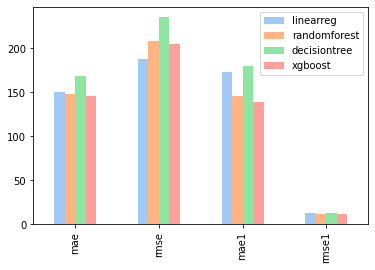

In [61]:
error_rec_tune = {
    "linearreg": {
        "mae": mae17_linear,
        "rmse": rmse17_linear,
        'mae1': 172.887 ,
        'rmse1': 13.149
    },
    "randomforest": {
        "mae": mae17_rf,
        "rmse": rmse17_rf,
        'mae1': 145.969,
        'rmse1': 12.085 
    },
    "decisiontree": {
        "mae": mae17_dtree,
        "rmse": rmse17_dtree,
        'mae1': 179.687 ,
        'rmse1': 13.405 
    },
    "xgboost": {
        "mae": mae17_xgb,
        "rmse": rmse17_xgb,
        'mae1': 138.506 ,
        'rmse1': 11.769 
    },
}

pd.DataFrame(error_rec_tune).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

In [63]:
# Save best grid search pipeline to file
dump_file_name = 'xgboost_blueberry_pollination_tuned_model.pkl'
joblib.dump(best_model_v0, dump_file_name, compress=1)
print('\nSaved %s tuned model to directory by name: %s' % (best_model_name_v0, dump_file_name))
    
# Save the random forest grid search pipleline for backup
dump_file_name1 = 'randomforest_blueberry_pollination_tuned_model.pkl'
joblib.dump(RF1, dump_file_name1, compress=1)
print('\nSaved %s tuned model to directory by name: %s' % ("Random Forest", dump_file_name1))


Saved XGBoost tuned model to directory by name: xgboost_blueberry_pollination_tuned_model.pkl

Saved Random Forest tuned model to directory by name: randomforest_blueberry_pollination_tuned_model.pkl


# Model Explainability (Explainable AI)

we have two models `RF1` and `best_model_v0` which is random forest and xgboost trained on the test set. we will visualize the model behavior and explainability.

[Shap Tree Explainer](https://shap.readthedocs.io/en/stable/example_notebooks/tabular_examples/tree_based_models/Fitting%20a%20Linear%20Simulation%20with%20XGBoost.html) has the code docs

In [117]:
# in the above cells, fit the model with the returned params from the gsearchCV
# and then passit to the shap arguements
fs_xgb = SelectKBest(score_func=mutual_info_regression, k=10)
fs_xgb.fit(X_train17,y_train17)
X_train_xgb = fs_xgb.transform(X_train17)
X_test_xgb = fs_xgb.transform(X_test17)
xgb_final = XGBRegressor(subsample=0.9)

xgb_final.fit(X_train_xgb, y_train17)
xgb_pred = xgb_final.predict(X_test_xgb)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [118]:
print(mean_absolute_error(y_test17,xgb_pred))
print(np.sqrt(mean_squared_error(y_test17,xgb_pred)))

135.53862935560554
198.57859357093267


In [119]:
fs_rf = SelectKBest(score_func=mutual_info_regression, k=11)
fs_rf.fit(X_train17,y_train17)
X_train_rf = fs_rf.transform(X_train17)
X_test_rf = fs_rf.transform(X_test17)
rf_final = RandomForestRegressor(max_depth=15, min_samples_split=2, criterion='mse')

rf_final.fit(X_train_rf,y_train17)
rf_pred = rf_final.predict(X_test_rf)

In [120]:
print(mean_absolute_error(y_test17,rf_pred))
print(np.sqrt(mean_squared_error(y_test17,rf_pred)))

147.84473783908876
207.70634260590876


In [148]:
feature_columns = [X17.columns[i] for i in range(len(fs_xgb.get_support())) if fs_xgb.get_support()[i]]
feature_columns

['clonesize',
 'honeybee',
 'osmia',
 'MinOfUpperTRange',
 'MaxOfLowerTRange',
 'RainingDays',
 'AverageRainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

In [171]:
pd.DataFrame(X_test_xgb, columns=[X17.columns[i] for i in range(len(fs_xgb.get_support())) if fs_xgb.get_support()[i]])

,clonesize,honeybee,osmia,MinOfUpperTRange,MaxOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,-0.896625,-0.173991,0.360355,1.295269,1.295373,-1.480852,-1.314321,1.581451,1.873162,1.942075
1,0.867790,-0.025436,1.020684,1.295269,1.295373,-0.228442,-0.379127,-0.186752,0.029807,-0.035623
2,0.867790,-0.025436,0.360355,-0.596118,-0.596339,1.274450,1.374363,0.196307,0.373607,0.295760
3,0.867790,-0.025436,0.360355,1.295269,1.295373,1.274450,1.374363,-1.265627,-0.876946,-0.935949
4,-0.896625,-0.173991,-0.355002,-0.596118,-0.596339,-1.480852,-1.314321,1.620438,1.849518,1.913516
...,...,...,...,...,...,...,...,...,...,...
252,0.867790,-0.025436,0.360355,-0.596118,-0.596339,-0.228442,-0.379127,-0.009834,0.163256,0.113112
253,0.867790,-0.025436,1.020684,-1.450879,-1.450661,1.274450,1.374363,-1.180600,-1.577228,-1.344093
254,0.867790,-0.173991,-1.015331,-0.596118,-0.596339,-1.480852,-1.314321,0.205625,0.383321,0.314906
255,0.867790,-0.173991,-1.730688,1.295269,1.295373,0.439510,0.380719,-2.252659,-1.859336,-1.884293


In [154]:
X_test_xgb_df = pd.DataFrame(X_test_xgb, columns=[X17.columns[i] for i in range(len(fs_xgb.get_support())) if fs_xgb.get_support()[i]])
X_test_rf_df = pd.DataFrame(X_test_rf, columns=[X17.columns[i] for i in range(len(fs_rf.get_support())) if fs_rf.get_support()[i]])

shap_values_xgb = shap.TreeExplainer(xgb_final).shap_values(X_test_xgb_df)
shap_interaction_values_xgb = shap.TreeExplainer(xgb_final).shap_interaction_values(X_test_xgb_df)

shap_values_rf = shap.TreeExplainer(rf_final).shap_values(X_test_rf_df)
shap_interaction_values_rf = shap.TreeExplainer(rf_final).shap_interaction_values(X_test_rf_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


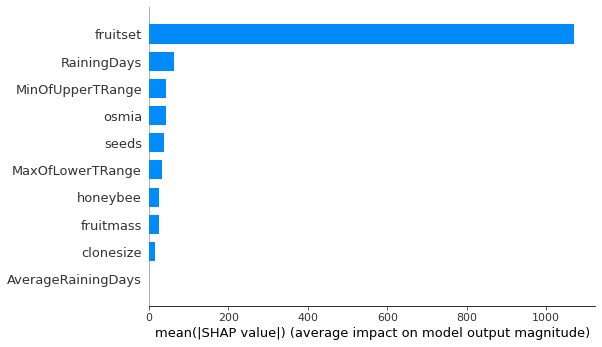

In [155]:
shap.summary_plot(shap_values_xgb, X_test_xgb_df, plot_type="bar")

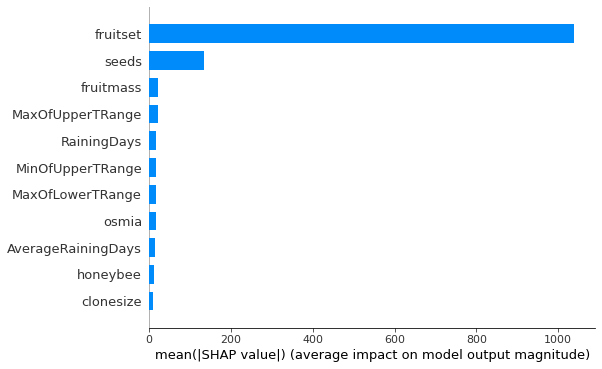

In [156]:
shap.summary_plot(shap_values_rf, X_test_rf_df, plot_type="bar")

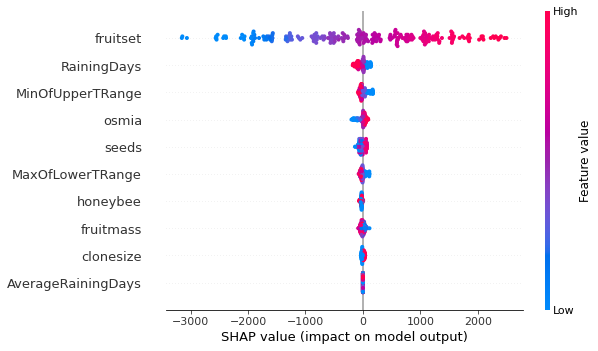

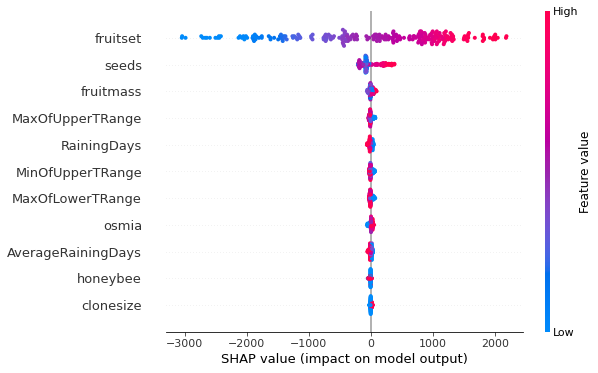

In [157]:
shap.summary_plot(shap_values_xgb, X_test_xgb_df)
shap.summary_plot(shap_values_rf, X_test_rf_df)

In [168]:
shap.initjs()

shap.force_plot(shap.TreeExplainer(xgb_final).expected_value, shap_values_xgb[50,0:-3], X_test_xgb_df.iloc[50,0:-3])


In [185]:
shap.force_plot(shap.TreeExplainer(rf_final).expected_value, shap_values_rf[120,0:-3], X_test_rf_df.iloc[120,0:-3])

In [172]:
shap.force_plot(shap.TreeExplainer(xgb_final).expected_value, shap_values_xgb[0:257,:], X_test_xgb_df.iloc[0:257,:])

# Saving Models and Backup Objects

<h3 style="color: red;"> Uncomment and run only if you wish to save </h3>

In [178]:
## uncomment to save the forceplot
# shap.force_plot(shap.TreeExplainer(xgb_final).expected_value, 
#                 shap_values_xgb[101,0:-3], 
#                 X_test_xgb_df.iloc[101,0:-3], 
#                 show=False, 
#                 matplotlib=True).savefig("force_plot_101.png")

In [189]:
# # Save best grid search pipeline to file
# dump_xgb_file_name = 'xgboost_blueberry_final_model.joblib'
# joblib.dump(xgb_final, dump_xgb_file_name, compress=1)
# print('\nSaved %s tuned model to directory by name: %s' % ("XGB final model", dump_xgb_file_name))
    
# # Save the random forest model for backup
# dump_rf_file_name = 'randomforest_blueberry_final_model.joblib'
# joblib.dump(rf_final, dump_rf_file_name, compress=1)
# print('\nSaved %s tuned model to directory by name: %s' % ("Random Forest model", dump_rf_file_name))


Saved XGB final model tuned model to directory by name: xgboost_blueberry_final_model.joblib

Saved Random Forest model tuned model to directory by name: randomforest_blueberry_final_model.joblib


In [193]:
# # Save feature selection objects for backup
# joblib.dump(fs_rf, "Randomforest_fs_object.joblib", compress=1)
# print("\n Saved %s to %s" % ("Randomforest fs object", "Randomforest_fs_object.joblib"))

# joblib.dump(fs_xgb, "XGB_fs_object.joblib", compress=1)
# print("\n Saved %s to %s" % ("XGB fs object", "XGB_fs_object.joblib"))

# # Save final test dataset for backup
# X_test_xgb_df.to_csv("X_test_xgb_df.csv")
# print("\nSaved X_test for XGB to CSV")
# X_test_rf_df.to_csv("X_test_rf_df.csv")
# print("\nSaved X_test for RF to CSV")

# # Save final training dataset for backup
# joblib.dump(X_train_xgb, "X_train_xgb.joblib")
# print("\n Saved X_train for XGB to joblib file")

# joblib.dump(X_train_rf, "X_train_rf.joblib")
# print("\n Saved X_train for RF to joblib file")



 Saved Randomforest fs object to Randomforest_fs_object.joblib

 Saved XGB fs object to XGB_fs_object.joblib

Saved X_test for XGB to CSV

Saved X_test for RF to CSV

 Saved X_train for XGB to joblib file

 Saved X_train for RF to joblib file


In [194]:
joblib.dump(y_test17, "y_test17.joblib", compress=1)
print("\nSaved y_test17 to joblib file")


Saved y_test17 to joblib file


In [247]:
# # xgb_final.predict(X_test_xgb_df.iloc[120,:].values.reshape(1,-1))

# xgb_final.predict(
#         np.array([37.5, 0.75, 0.25, 0.25, 86.0, 62.0, 16.0, 0.26, 0.410652, 0.408159]).reshape(1,-1)
# )

array([6159.933], dtype=float32)

In [231]:
# # Forceplot with external query, with 
# shap.force_plot(shap.TreeExplainer(xgb_final).expected_value, #pass the model
#                 shap.TreeExplainer(xgb_final).shap_values(X_test_xgb_df.iloc[120,:].values.reshape(1,-1)), #pass query, will give the prediction
#                 X_test_xgb_df.iloc[120,:]) # pass the query in form of dataframe

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 648x936 with 0 Axes>

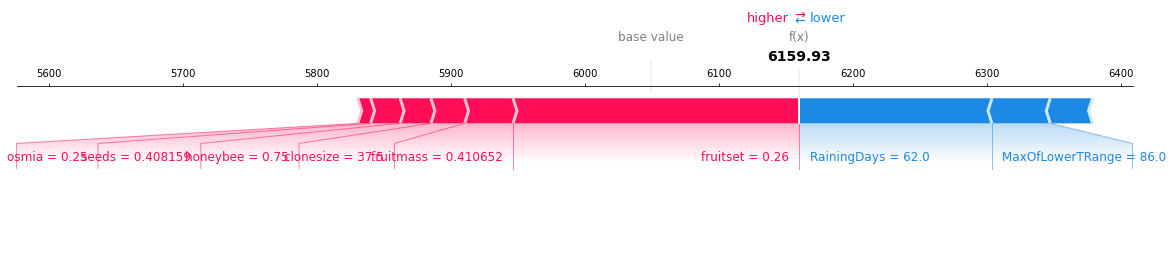

In [251]:
plt.figure(figsize=(9,13))
shap.force_plot(shap.TreeExplainer(xgb_final).expected_value, #pass the model
                shap.TreeExplainer(xgb_final).shap_values(np.array([37.5, 0.75, 0.25, 0.25, 86.0, 62.0, 16.0, 0.26, 0.410652, 0.408159]).reshape(1,-1)), #pass query, will give the prediction
                np.array([37.5, 0.75, 0.25, 0.25, 86.0, 62.0, 16.0, 0.26, 0.410652, 0.408159]).reshape(1,-1),
                feature_names=feature_columns,
               show=False,
               matplotlib=True).savefig("test_for_plot.png", bbox_inches = 'tight') # pass the query in form of dataframe